# CCM Final Project
#### Baysian Modeling of Orientation WM prior

### Content
1. Load and Sort data
2. Prior Model Simulate
3. Fit Prior Model
4. Validation of Prior Model (Recover the params from the simulated data)

### 1. Load and Sort Data

In [255]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [256]:
curr_dif = os.getcwd()
data_dir = os.path.abspath(os.path.join(curr_dif, '..\\..\\'))
os.listdir(data_dir)

['.Rhistory',
 '.Rproj.user',
 'CCM_finalProject',
 'CCM_Final_23Spring.Rproj',
 'data',
 'data_beh.csv',
 'figures',
 'scripts']

In [257]:
data_path = os.path.join(data_dir,'data_beh.csv')
data = pd.read_csv(data_path,sep=',')

data.head()

,subjID,run,trial,phase,oriRef,oriJitt,oriFinal,oriRespInit,oriRespFinal,error,points,rt,outoftime,iti
0,1,1,1,9,2,-9,36,63,62,-26,48,2.609021,NaN,0.2
1,1,1,2,3,1,-9,171,85,165,6,88,3.047162,NaN,0.2
2,1,1,3,4,2,-1,44,58,53,-9,82,2.500657,NaN,0.2
3,1,1,4,1,3,6,96,12,99,-3,94,3.697208,NaN,0.2
4,1,1,5,3,4,3,138,43,143,-5,90,3.665645,NaN,0.2


In [258]:
data_df = pd.DataFrame(data)
flag = data_df['outoftime']!=1
print(sum(flag))
data_clean = data_df[flag]
data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
data_clean['oriRespFinal2'] = data_clean['oriFinal2'] - data_clean['error']
data_clean['oriFinal3'] = data_clean['oriJitt']
data_clean['oriRespFinal3'] = data_clean['oriRespFinal2'] - data_clean['oriRef2']
data_clean = data_clean[data_clean['error'].abs() < 22.55]
data_clean

2319


C:\Users\kay\AppData\Local\Temp\ipykernel_24304\3190871318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
C:\Users\kay\AppData\Local\Temp\ipykernel_24304\3190871318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
C:\Users\kay\AppData\Local\Temp\ipykernel_24304\3190871318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,subjID,run,trial,phase,oriRef,oriJitt,oriFinal,oriRespInit,oriRespFinal,error,points,rt,outoftime,iti,oriRef2,oriFinal2,oriRespFinal2,oriFinal3,oriRespFinal3
1,1,1,2,3,1,-9,171,85,165,6,88,3.047162,NaN,0.2,0,-9,-15,-9,-15
2,1,1,3,4,2,-1,44,58,53,-9,82,2.500657,NaN,0.2,45,44,53,-1,8
3,1,1,4,1,3,6,96,12,99,-3,94,3.697208,NaN,0.2,90,96,99,6,9
4,1,1,5,3,4,3,138,43,143,-5,90,3.665645,NaN,0.2,135,138,143,3,8
5,1,1,6,7,1,-9,171,152,164,7,86,1.547777,NaN,0.2,0,-9,-16,-9,-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,15,1,155,7,3,-1,89,93,88,1,98,2.375790,NaN,0.2,90,89,88,-1,-2
2395,15,1,156,1,3,0,90,18,91,-1,98,2.757365,NaN,0.2,90,90,91,0,1
2397,15,1,158,5,4,1,136,149,127,9,82,2.387765,NaN,0.2,135,136,127,1,-8
2398,15,1,159,2,2,-6,39,20,46,-7,86,1.181797,NaN,0.2,45,39,46,-6,1


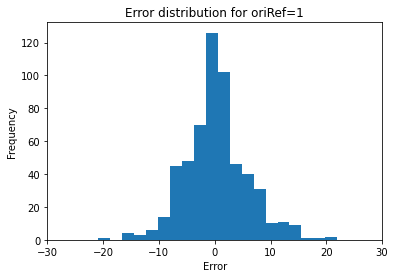

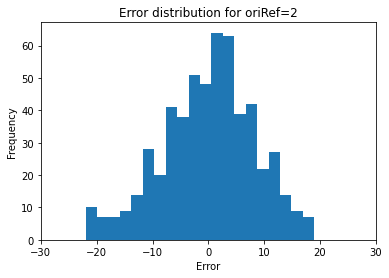

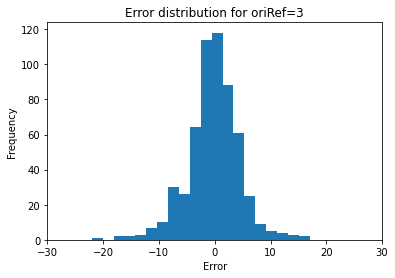

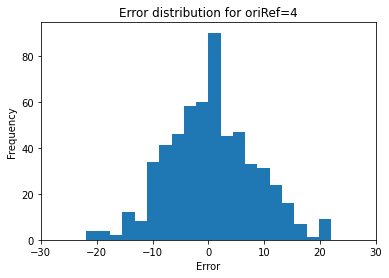

In [259]:
oriRefs = np.unique(data_clean['oriRef'])

for oriRef in oriRefs:
    data_oriRef = data_clean[data_clean['oriRef'] == oriRef]
    plt.hist(data_oriRef['error'], bins=20)
    plt.xlim(-30, 30)
    plt.title(f'Error distribution for oriRef={oriRef}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

### Prior Model Simulate

In [260]:
def prior_simulate_data(targ_loc,prior_mu,prior_std,likelihood_std):
    
    posterior = [];
    answers = [];
    xs = np.linspace(-90, 90, 181)
    for i in range(targ_loc.shape[0]):
        representation = norm.pdf(xs, loc=targ_loc[i], scale=likelihood_std)
        prior = norm.pdf(xs, loc=prior_mu[i], scale=prior_std)
        post = representation * prior
        post = post/sum(post) # normalize
        
        random_answer = np.random.choice(xs,p = post)
        answers.append(random_answer)
        posterior.append(post[round(random_answer)])
        #errors = answers-targ_loc
    return answers,posterior

In [261]:
def no_prior_simulate_data(targ_loc, likelihood_std):
    posterior = []
    answers = []
    xs = np.linspace(-90, 90, 181)
    
    # Uniform prior
    prior = np.ones_like(xs) / len(xs)
    
    for i in range(targ_loc.shape[0]):
        # Likelihood (representation) using a normal distribution
        representation = norm.pdf(xs, loc=targ_loc[i], scale=likelihood_std)
        
        # Posterior is the product of the likelihood and the uniform prior
        post = representation * prior
        post = post / sum(post)  # Normalize
        
        # Sample a random answer from the possible orientations
        random_answer = np.random.choice(xs, p=post)
        answers.append(random_answer)
        posterior.append(post[round(random_answer)])
        
    return answers, posterior

### 3.Fit Prior Model

In [262]:
from scipy.special import logsumexp

def negative_log_likelihood_piror(targ_loc, real_response, prior_std, likelihood_std):
    nll = 0
    xs = np.linspace(-90, 90, 181)
    prior_mu = 0
    for i in range(targ_loc.shape[0]):
        # Calculate the log of likelihood
        likelihood = norm.logpdf(real_response[i], loc=targ_loc[i], scale=likelihood_std)
        # Calculate the log of prior
        prior = norm.logpdf(real_response[i], loc=prior_mu, scale=prior_std)
        # Calculate the unnormalized log-posterior
        log_unnormalized_posterior = likelihood + prior
        # Compute the log of the normalization constant (log of P(S))
        log_normalization_constant = logsumexp(norm.logpdf(xs, loc=targ_loc[i], scale=likelihood_std) + norm.logpdf(xs, loc=prior_mu, scale=prior_std))
        # Calculate the log-posterior
        log_posterior = log_unnormalized_posterior - log_normalization_constant
        # Update the nll
        nll -= log_posterior
    return nll

def wrapped_negative_log_likelihood_prior(params, targ_loc, real_response):
    prior_std, likelihood_std = params
    return negative_log_likelihood_piror(targ_loc, real_response, prior_std, likelihood_std)

# Set initial guesses for prior_std and likelihood_std
init_guess_prior = [10, 20]  # [prior_std_guess, likelihood_std_guess]

In [263]:
# stability fix
def negative_log_likelihood_no_prior(targ_loc, real_response, likelihood_std):
    nll = 0
    for i in range(targ_loc.shape[0]):
        # Calculate the log of likelihood
        likelihood = norm.logpdf(real_response[i], loc=targ_loc[i], scale=likelihood_std)
        # Update the nll
        nll -= likelihood
    return nll

def wrapped_negative_log_likelihood_no_prior(params, targ_loc, real_response):
    likelihood_std = params[0]
    return negative_log_likelihood_no_prior(targ_loc, real_response, likelihood_std)

# Initial guess for likelihood_std
initial_guess_no_prior = np.array([20])

In [270]:
unique_oriRef2 = data_clean['oriRef2'].unique()
unique_SubjID = data_clean['subjID'].unique()

results = []

for i in unique_SubjID:
    for j in unique_oriRef2:
        subset = data_clean[(data_clean['oriRef2'] == j) & (data_clean['subjID'] == i)]
        targ_loc = np.array(subset['oriFinal3'])
        real_response = np.array(subset['oriRespFinal3'])
        
        # Minimize the negative log-likelihood with prior
        result_prior = minimize(wrapped_negative_log_likelihood_prior, init_guess_prior, 
                                args=(targ_loc, real_response), bounds=((1e-5, 100), (1e-5, 100)))
        estimated_prior_std, estimated_likelihood_std = result_prior.x
        nll_prior = result_prior.fun

        # Minimize the negative log-likelihood without prior
        result_no_prior = minimize(wrapped_negative_log_likelihood_no_prior, initial_guess_no_prior, 
                                   args=(targ_loc, real_response), bounds=((1e-5, 100),))
        estimated_likelihood_std_no_prior = result_no_prior.x[0]
        nll_no_prior = result_no_prior.fun

        results.append({
            'subjID': i,
            'oriRef2': j,
            'nll_prior': nll_prior,
            'prior_std': estimated_prior_std,
            'likelihood_std': estimated_likelihood_std,
            'nll_no_prior': nll_no_prior,
            'likelihood_std_no_prior': estimated_likelihood_std_no_prior
        })

results_df = pd.DataFrame(results)

In [265]:
results_df

,subjID,oriRef2,nll_prior,prior_std,likelihood_std,nll_no_prior,likelihood_std_no_prior
0,1,0,129.162705,20.000000,5.968507,126.672535,5.742385
1,1,45,145.439159,20.000000,10.622611,143.029257,9.473308
2,1,90,121.302991,20.000000,4.938446,119.554194,4.806247
3,1,135,137.009416,20.000000,7.791873,136.285647,7.302393
4,2,0,128.837843,20.000000,6.058597,127.196321,5.818078
5,2,45,138.439263,17.925613,9.539796,138.933948,8.528986
6,2,90,115.403492,20.000000,4.294504,114.228834,4.207133
7,2,135,133.970552,20.000000,7.310093,133.951072,6.888395
8,3,0,129.954613,20.000000,6.085352,127.372793,5.843804
9,3,45,142.187695,20.000000,9.113073,141.620015,8.344166


### 4. Validation of Model (Recover the params from the simulated data)

In [271]:
def generate_synthetic_data(n_samples, prior_mu, prior_std, likelihood_std):
    real_response = []
    # Generate target locations (targ_loc) from the prior
    targ_loc = np.random.normal(prior_mu, prior_std, n_samples)
    # Generate real_response values by adding noise to the targ_loc values
    for i in targ_loc:
        real_response.append(i + np.random.normal(0, likelihood_std))
    return targ_loc, np.array(real_response)

n_samples = 1000
prior_mu = 0

prior_std = 10
likelihood_std = 10

targ_loc, real_response = generate_synthetic_data(n_samples, prior_mu, prior_std, likelihood_std)

In [272]:
result_prior_synthetic = minimize(wrapped_negative_log_likelihood_prior, init_guess_prior, 
                                  args=(targ_loc, real_response), bounds=((1e-5, 100), (1e-5, 15)))
recovered_prior_std, recovered_likelihood_std = result_prior_synthetic.x

result_no_prior_synthetic = minimize(wrapped_negative_log_likelihood_no_prior, initial_guess_no_prior, 
                                     args=(targ_loc, real_response), bounds=((1e-5, 100),))
recovered_likelihood_std_no_prior = result_no_prior_synthetic.x[0]

print("True prior_std:", true_prior_std)
print("Recovered prior_std:", recovered_prior_std)
print("True likelihood_std:", true_likelihood_std)
print("Recovered likelihood_std (with prior):", recovered_likelihood_std)
print("Recovered likelihood_std (without prior):", recovered_likelihood_std_no_prior)

True prior_std: 10
Recovered prior_std: 100.0
True likelihood_std: 10
Recovered likelihood_std (with prior): 9.989828112759884
Recovered likelihood_std (without prior): 9.940802533055312


In [273]:
print(negative_log_likelihood_piror(targ_loc, real_response, 10, 10))

4123.524303458041


In [274]:
print(negative_log_likelihood_piror(targ_loc, real_response, 20, 10))

3754.6386088486697
